# Structural and functional annotation of Gryllus longicercus

Szymon Szrajer 17-10-23

### This notebook consists of 13 steps and covers the analysis for the structural and functional annotation of Gryllus longicercus project.

## 1. Prepare RNAseq evidence (BAM files).

RNA-Seq evidence for annotation.

### 1a. Download fastq.gz files

In [ ]:
%%bash 
# download fastq.gz files
cd /path_to/fastq
wget -O 00_fastq.zip https://www.dropbox.com/<link>

In [ ]:
%%bash 
# unzip fastq.gz folder
cd /path_to/fastq
unzip 00_fastq.zip

In [ ]:
ls /path_to/fastq

FB12_R1.fastq.gz*  FT12_R2.fastq.gz*   MB11_R1.fastq.gz*  MT12_R2.fastq.gz*
FB12_R2.fastq.gz*  FT13_R1.fastq.gz*   MB11_R2.fastq.gz*  MT13_R1.fastq.gz*
FB13_R1.fastq.gz*  FT13_R2.fastq.gz*   MB12_R1.fastq.gz*  MT13_R2.fastq.gz*
FB13_R2.fastq.gz*  FTA11_R1.fastq.gz*  MB12_R2.fastq.gz*  MTA11_R1.fastq.gz*
FB4_R1.fastq.gz*   FTA11_R2.fastq.gz*  MB13_R1.fastq.gz*  MTA11_R2.fastq.gz*
FB4_R2.fastq.gz*   FTA12_R1.fastq.gz*  MB13_R2.fastq.gz*  MTA12_R1.fastq.gz*
FT11_R1.fastq.gz*  FTA12_R2.fastq.gz*  MT11_R1.fastq.gz*  MTA12_R2.fastq.gz*
FT11_R2.fastq.gz*  FTA13_R1.fastq.gz*  MT11_R2.fastq.gz*  MTA13_R1.fastq.gz*
FT12_R1.fastq.gz*  FTA13_R2.fastq.gz*  MT12_R1.fastq.gz*  MTA13_R2.fastq.gz*


In [ ]:
#count the number of reads

In [ ]:
%%bash
for file in /path_to/fastq/* 
do
    echo $file
    zcat $file | wc -l | awk '{print $1/4}'
done


### 1b. Run FastQC

In [ ]:
%%bash
cd /path_to/fastq
/path_to/software/FastQC/fastqc -o ../qc_precut -t 30 *gz

### 1c. Run Trim Galore!

In [ ]:
%%bash
cd /path_to/fastq
for r1_file in *_R1.fastq.gz; do
    # get_ the corresponding R2 file name by replacing "_R1" with "_R2"
    r2_file=${r1_file/_R1/_R2}
    
    /path_to/software/TrimGalore-0.6.10/trim_galore --paired -j 5 ${r1_file} ${r2_file}

    done

### 1d. Run FastQC


In [ ]:
%%bash
cd /path_to/fastq_trim
/path_to/software/FastQC/fastqc -o ../qc_postcut -t 30 *gz

### 1d. Run HISAT2!

In [ ]:
%%bash
cd /path_to/genomes
# build ht2 genome index
/path_to/software/hisat2-2.2.1/hisat2-build -p 30 Glon_curated.fasta Glon

In [ ]:
%%bash
cd /path_to/fastq_trim

#!/bin/bash
for fileR1 in *_R1_*gz; do
  # $file is the absolute path
  fileR2=$(echo $fileR1 | sed 's/R1_val_1/R2_val_2/')
  sampleR1=$(basename $fileR1 _R1_val_1.fq.gz)
  # print the results to stdout
  echo "$sampleR1,$fileR1"
  # here, the --dta flag is necessary to ensure that HISAT2 output can be used in the BRAKER3 pipeline.
  /path_to/software/hisat2-2.2.1/hisat2 --dta -q -p 20 -x /path_to/genomes/Glon -1 ${fileR1} -2 ${fileR2} \
    -S /path_to/bam/${sampleR1}.sam &> /path_to/bam/${sampleR1}_summary.txt
  /opt/samtools-1.17/samtools view -b /path_to/bam/${sampleR1}.sam  > /path_to/bam/${sampleR1}.bam
  rm /path_to/bam/${sampleR1}.sam
  done


## 2. Prepare protein evidence.

As for the BRAKER3 team's suggestion, the base protein set for this annotation was a set of 2.1Gb Arthropoda proteins from OrthoDB.

https://bioinf.uni-greifswald.de/bioinf/partitioned_odb11/

Then we supplemented the database with grylli proteins from NCBI:

- [Gryllus bimaculatus *(25687)](https://www.ncbi.nlm.nih.gov/protein?term=txid6998%5BOrganism%5D#)
(((txid6998[Organism]) AND "Gryllus bimaculatus"[porgn:__txid6999])) AND PRJDB10609 (*PRJDB10609 is a BioProject)*
- [Gryllus pennsylvanicus x Gryllus firmus *(677)*](https://www.ncbi.nlm.nih.gov/protein?term=txid6998%5BOrganism%5D#)
- [Gryllus veletis *(98)](https://www.ncbi.nlm.nih.gov/protein?term=txid6998%5BOrganism%5D#)* (txid6998[Organism]) AND "Gryllus veletis"[porgn:__txid51040]
- [All other taxa *(185)](https://www.ncbi.nlm.nih.gov/protein?term=txid6998%5BOrganism%5D#)* (txid6998[Organism]) NOT "Gryllus veletis"[porgn:__txid51040] NOT "Gryllus pennsylvanicus"[porgn:__txid51074] NOT "Gryllus firmus"[porgn:__txid7000] NOT "Gryllus pennsylvanicus x Gryllus firmus"[porgn:__txid658220] NOT "Gryllus bimaculatus"[porgn:__txid6999]

In [ ]:
%%bash

cd /path_to/protein/supplementary # folder with downloaded NCBI sequences
cat *fasta > Gryllus_proteins.fasta

Before adding NCBI proteins to the OrthoDB database we also made sure that FASTA headers of the proteins don’t cause problems inside Augustus (as they tend to do that). To achieve a similar format to that of OrthoDB, we ran the following:

In [27]:
def replace_fasta_headers(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    with open(file_path, 'w') as file:
        for line in lines:
            if line.strip():  # check if line is not empty
                if line.startswith('>'):
                    header = line.strip().split()[0][1:]  # extract the first word without '>'
                    file.write(f'>{header} {header}\n')
                else:
                    file.write(line)


file_path = '/path_to/protein/Gryllus_proteins.fasta'
replace_fasta_headers(file_path)

Join the protein files together

In [28]:
%%bash
cd /path_to/protein
cat Arthropoda.fa Gryllus_proteins.fasta > proteinDB.fasta

## 3. Mask the genome.


To stop the annotation pipeline from picking up unnecessary signal we have masked the genome.

### 1a. Using the RepBase library 

In [ ]:
# run on 10.10.4.125
!/path_to/RepeatMasker -pa 20 -small -lib \
/path_to/libraries/RB.lib.fa /path_to/Glon_curated.fasta -gff \
-dir /path_to/soft_repbase/

### 1b. Using Gbim repeat library:

In [ ]:
# run on 10.10.4.125
!/path_to/RepeatMasker -pa 20 -small -lib \
/path_to/libraries/Gbi_Rep_CombinedLibrary.lib.minlen50.nr.classified.filtered.fa \
/path_to/Glon_curated.fasta -gff \
-dir /path_to/soft_gbimlib/

### 2. Check masking with BUSCO

In [41]:
%%bash
cd /path
docker pull ezlabgva/busco:v5.5.0_cv1
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1

In [ ]:
%%bash
cd /path

docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/genomes/Glon_curated.fasta -o geno_a --out_path /busco_wd/buscos -m geno --augustus -l arthropoda -c 35 
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/genomes/Glon_curated.fasta -o geno_i --out_path /busco_wd/buscos -m geno --augustus -l insecta -c 35 
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/masking/soft_repbase/Glon_curated.fasta.masked -o rep_a --out_path /busco_wd/buscos -m geno --augustus -l arthropoda -c 35 
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/masking/soft_repbase/Glon_curated.fasta.masked -o rep_i --out_path /busco_wd/buscos -m geno --augustus -l insecta -c 35 
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/masking/soft_gbimlib/Glon_curated.fasta.masked -o gbim_a --out_path /busco_wd/buscos -m geno --augustus -l arthropoda -c 35 
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/masking/soft_gbimlib/Glon_curated.fasta.masked -o gbim_i --out_path /busco_wd/buscos -m geno --augustus -l insecta -c 35 

### 3. Transform into a soft masking

In [59]:
!/path_to/software/bedtools2/bin/bedtools maskfasta -soft -fi /path_to/genomes/Glon_curated.fasta \
-bed /path_to/masking/soft_gbimlib/Glon_curated.fasta.out.gff \
-fo /path_to/masking/soft_gbimlib_bed/Glon_soft_masked.fasta

## 4. Run BRAKER3

 The structural annotation itself.

### 1. BRAKER3 run with Docker

In [ ]:
!sudo docker run --user 1000:100 --rm -it \
    -v /path:/home/jovyan/ \
    teambraker/braker3:latest bash -c \
    "braker.pl --genome=/home/jovyan/masking/soft_gbimlib_bed/Glon_soft_masked.fasta --workingdir=/home/jovyan/annotation --threads=30 --gff3 --prot_seq=/home/jovyan/protein/proteinDB.fasta --bam=/home/jovyan/bam/FB12.bam,/home/jovyan/bam/FB13.bam,/home/jovyan/bam/FB4.bam,/home/jovyan/bam/FT11.bam,/home/jovyan/bam/FT12.bam,/home/jovyan/bam/FT13.bam,/home/jovyan/bam/FTA11.bam,/home/jovyan/bam/FTA12.bam,/home/jovyan/bam/FTA13.bam,/home/jovyan/bam/MB11.bam,/home/jovyan/bam/MB12.bam,/home/jovyan/bam/MB13.bam,/home/jovyan/bam/MT11.bam,/home/jovyan/bam/MT12.bam,/home/jovyan/bam/MT13.bam,/home/jovyan/bam/MTA11.bam,/home/jovyan/bam/MTA12.bam,/home/jovyan/bam/MTA13.bam &> /home/jovyan/annotation/run.log"


### 2. Check Annotation's BUSCO score

In [8]:
! gffread /path_to/annotation/braker.gff3 -y /path_to/annotation/Glon_prots.fa -g /path_to/genomes/Glon_curated.fasta

In [ ]:
%%bash
cd /path_to

docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/annotation/Glon_prots.fa -o prot_a --out_path /busco_wd/buscos -m protein --augustus -l arthropoda -c 35 
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/annotation/Glon_prots.fa -o prot_i --out_path /busco_wd/buscos -m protein --augustus -l insecta -c 35

## 5. BLAST functional annotation

Part of the functional annotation was BLAST annotation.

We first started with BLASTing against Swissprot Insecta, then continued with TrEMBL Insecta and tried to get a BLAST hit for the third time with Swissprot without taxonomy filtering.

In [5]:
# Swissprot Insecta  9690 proteins
SI = "/path_to/revieved_insecta/revieved_swisssecta.fasta"
# TrEMBL Insecta 5683201 proteins
TI = "/path_to/unrevieved_insecta/unrevieved_insecta.fasta"
# Swissprot, no taxononomy filtering 569793 proteins
SA = "/path_to/revieved_all/uniprot_sprot.fasta"

In [ ]:
!makeblastdb -in $SI -dbtype prot -input_type fasta
!makeblastdb -in $TI -dbtype prot -input_type fasta
!makeblastdb -in $SA -dbtype prot -input_type fasta

In [6]:
query = "/path_to/Glon_single_transcript.fa" # single transcript method below

In [ ]:
!blastp -num_threads 20 -query $query -db $SI -outfmt '6 std stitle' -out /path_to/libraries/revieved_insecta/SI_results2.blastp -evalue 1e-6 \
-max_hsps 1 -max_target_seqs 1 

In [ ]:
!blastp -num_threads 20 -query $query -db $TI -outfmt '6 std stitle' -out /path_to/libraries/unrevieved_insecta/UI_results2.blastp -evalue 1e-6 \
-max_hsps 1 -max_target_seqs 1 

In [ ]:
!blastp -num_threads 20 -query $query -db $SA -outfmt '6 std stitle' -out /path_to/libraries/revieved_all/SA_results2.blastp -evalue 1e-6 \
-max_hsps 1 -max_target_seqs 1

In [27]:
results_A = {}
results_B = {}
results_C = {}



with open("/path_to/libraries/revieved_insecta/SI_results2.blastp", "r") as file_A:
    for line in file_A:
        fields = line.strip().split("\t")
        results_A[fields[0]] = line

with open("/path_to/libraries/unrevieved_insecta/UI_results2.blastp", "r") as file_B:
    for line in file_B:
        fields = line.strip().split("\t")
        # check if the protein ID already exists in A results, if not, add it
        if fields[0] not in results_A:
            results_B[fields[0]] = line

with open("/path_to/libraries/revieved_all/SA_results2.blastp", "r") as file_C:
    for line in file_C:
        fields = line.strip().split("\t")
        # check if the protein ID already exists in A or B results, if not, add it
        if fields[0] not in results_A and fields[0] not in results_B:
            results_C[fields[0]] = line

In [29]:
print(len(results_A)) #7558
print(len(results_B)) #5261
print(len(results_C)) #7

7558
5261
7


In [28]:
merged_results = {**results_A, **results_B, **results_C}

# write the merged results to an output file
with open("merged_results.txt", "w") as output_file:
    for result in merged_results.values():
        output_file.write(result)

## 6. InterProScan functional annotaion

We used InterProScan to supplement the functional annotation.

In [ ]:
!head /path_to/single_transcripts/Glon/Glon_single_transcript.fa

In [46]:
!grep -c ">" /path_to/single_transcripts/Glon/Glon_single_transcript.fa

19761


In [ ]:
# there was an error with an annotation of gene 14096, I removed the fasta record (the protein was 17 amino acids long with two "." signs)

In [ ]:
!/path_to/installation/interproscan-5.63-95.0/interproscan.sh -i /path_to/single_transcripts/Glon/Glon_single_transcript.fa -f TSV -appl Pfam -goterms -cpu 20 -verbose -o /path_to/functional/ipr_out2


## 7. OrthoFinder relationships

We checked the OrthoFinder relationships of amino acid sequences of the longest transcript for _Gryllus longicercus_ and 5 other species.

In [ ]:
!docker run -it --rm davidemms/orthofinder orthofinder -h


In [ ]:
# sed -E -i '/^[^>]/ s/\.//g' *.fa

In [ ]:
!docker run --ulimit nofile=100000:100000 -it --rm -v /path_to/single_OF:/input:Z davidemms/orthofinder orthofinder -f /input


In [33]:
%%bash

cat Species_Tree/SpeciesTree_rooted.txt


((Aasa:0.216454,Lkoh:0.22336)0.755644:0.085904,((Gbim:0.0701653,Glon:0.033088)0.555054:0.0402281,(Tocc:0.0517169,Toce:0.106967)0.44373:0.0403061)0.755644:0.085904);

In [34]:
from Bio import Phylo

tree = Phylo.read("/path_to/Species_Tree/SpeciesTree_rooted.txt", "newick")
print(tree)

Tree(rooted=False, weight=1.0)
    Clade()
        Clade(branch_length=0.085904, confidence=0.755644)
            Clade(branch_length=0.216454, name='Aasa')
            Clade(branch_length=0.22336, name='Lkoh')
        Clade(branch_length=0.085904, confidence=0.755644)
            Clade(branch_length=0.0402281, confidence=0.555054)
                Clade(branch_length=0.0701653, name='Gbim')
                Clade(branch_length=0.033088, name='Glon')
            Clade(branch_length=0.0403061, confidence=0.44373)
                Clade(branch_length=0.0517169, name='Tocc')
                Clade(branch_length=0.106967, name='Toce')


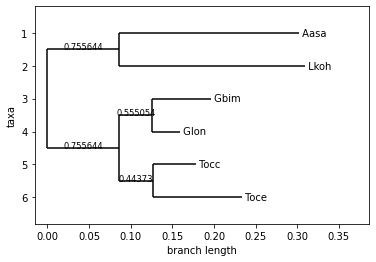

In [35]:
Phylo.draw(tree)

## 8. Run BUSCOs on longest transcript per gene sets

BUSCO served as a QC measure throught the study.

In [ ]:
%%bash
cd /path_to/single_transcripts

docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/Aasa/Aasa_single_transcript.fa  -o AASA_a --out_path /busco_wd/outputs -m protein --augustus -l arthropoda -c 35 
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/Aasa/Aasa_single_transcript.fa  -o AASA_i --out_path /busco_wd/outputs -m protein --augustus -l insecta -c 35
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/Glon/Glon_single_transcript.fa -o GLON_a --out_path /busco_wd/outputs -m protein --augustus -l arthropoda -c 35 
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/Glon/Glon_single_transcript.fa -o GLON_i --out_path /busco_wd/outputs -m protein --augustus -l insecta -c 35
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/Tocc/Tocc_single_transcript.fa -o TOCC_a --out_path /busco_wd/outputs -m protein --augustus -l arthropoda -c 35 
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/Tocc/Tocc_single_transcript.fa -o TOCC_i --out_path /busco_wd/outputs -m protein --augustus -l insecta -c 35
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/Gbim/Gbim2_single_transcript.fa -o GBIM_a --out_path /busco_wd/outputs -m protein --augustus -l arthropoda -c 35 
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/Gbim/Gbim2_single_transcript.fa -o GBIM_i --out_path /busco_wd/outputs -m protein --augustus -l insecta -c 35
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/Lkoh/Lkoh_single_transcript.fa -o LKOH_a --out_path /busco_wd/outputs -m protein --augustus -l arthropoda -c 35 
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/Lkoh/Lkoh_single_transcript.fa -o LKOH_i --out_path /busco_wd/outputs -m protein --augustus -l insecta -c 35
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/Toce/Toce_single_transcript.fa -o TOCE_a --out_path /busco_wd/outputs -m protein --augustus -l arthropoda -c 35 
docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/Toce/Toce_single_transcript.fa -o TOCE_i --out_path /busco_wd/outputs -m protein --augustus -l insecta -c 35

## 9. Merge functional annotations

Matching InterProScan and BLAST result back witch gff IDs.

In [13]:
import pandas as pd
from Bio import SeqIO

ipr = pd.read_table("/path_to/functional/ipr_out2", sep='\t', header=None)

In [ ]:
ipr2 = ipr.drop(ipr.columns[[1,2,3,5,6,7,8,9,10,12]], axis = 1)

In [22]:
ipr2.columns = ['Header','Pfam','InterPro','GO']

In [ ]:
ipr2['GO'] = ipr2['GO'].str.replace('|', ',')


In [34]:
ipr2['GO'] = ipr2['GO'].astype(str)


In [ ]:
merged_ipr = ipr2.groupby('Header').agg(lambda x: ','.join(x))
merged_ipr = merged_ipr.reset_index()

In [36]:
def remove_duplicates(cell):
    values = cell.split(',')
    unique_values = ','.join(filter(lambda x: x != '-', pd.unique(values)))
    return unique_values

merged_ipr = merged_ipr.applymap(remove_duplicates)

In [ ]:
def fasta_to_dataframe(fasta_file):
    headers = []

    for record in SeqIO.parse(fasta_file, "fasta"):
        headers.append(record.id)

    df = pd.DataFrame({"Header": headers})

    return df

fasta_file_path = '/path_to/single_transcripts/Glon/Glon_single_transcript.fa'
df = fasta_to_dataframe(fasta_file_path)

In [ ]:
merged_df = pd.merge(df, merged_ipr, on='Header', how='left')

In [ ]:
merged_df = merged_df.fillna(pd.NA)
merged_df = merged_df.replace({'': pd.NA, None: pd.NA})

In [41]:
non_na = merged_df.count()
non_na

Header      14832
Pfam        10962
InterPro    10727
GO           7056
dtype: int64

In [ ]:
blast_df = pd.DataFrame([value.split('\t') for value in merged_results.values()],
                  index=merged_results.keys())


In [ ]:
blast_df = blast_df.drop(blast_df.columns[[2,3,4,5,6,7,8,9,10,11]], axis = 1)


In [ ]:
blast_df.columns = ['Header','BLAST_ID','Info']

In [53]:
blast_df.iloc[0,2]

'sp|A1ZAI5|FACR1_DROME Putative fatty acyl-CoA reductase CG5065 OS=Drosophila melanogaster OX=7227 GN=CG5065 PE=3 SV=1\n'

In [ ]:
pattern = r'^(\S+) (.+?) OS=(.+?) OX=.+?$'

# apply the pattern to BlastP output and create three new columns
blast_df[['Protein_ID', 'Gene_Description', 'Organism']] = blast_df['Info'].str.extract(pattern)

print(blast_df)

In [ ]:
merged_blast = pd.merge(merged_df, blast_df, on='Header', how='left')
merged_blast = merged_blast.fillna(pd.NA)

In [80]:
import numpy as np

In [ ]:
merged_blast.replace('<NA>', np.nan, inplace=True)

In [82]:
non_na = merged_blast.count()
non_na

Header              14832
Pfam                10962
InterPro            10727
GO                   7056
BLAST_ID            12826
Info                12826
Protein_ID          12826
Gene_Description    12826
Organism            12826
dtype: int64

In [83]:
merged_blast = merged_blast.drop(merged_blast.columns[[4,5]], axis = 1)
merged_blast

,Header,Pfam,InterPro,GO,Protein_ID,Gene_Description,Organism
0,g1.t1,PF07993,IPR013120,<NA>,sp|A1ZAI5|FACR1_DROME,Putative fatty acyl-CoA reductase CG5065,Drosophila melanogaster
1,g2.t1,PF07993,IPR013120,<NA>,sp|A1ZAI5|FACR1_DROME,Putative fatty acyl-CoA reductase CG5065,Drosophila melanogaster
2,g3.t2,"PF07993,PF03015","IPR013120,IPR033640",<NA>,sp|A1ZAI5|FACR1_DROME,Putative fatty acyl-CoA reductase CG5065,Drosophila melanogaster
3,g4.t1,<NA>,<NA>,<NA>,sp|Q8MS59|WAT_DROME,Fatty acyl-CoA reductase wat,Drosophila melanogaster
4,g5.t1,"PF03015,PF07993","IPR033640,IPR013120",<NA>,sp|A1ZAI5|FACR1_DROME,Putative fatty acyl-CoA reductase CG5065,Drosophila melanogaster
...,...,...,...,...,...,...,...
14827,g14829.t1,PF16661,IPR001279,<NA>,sp|Q95TS5|INT9_DROME,Integrator complex subunit 9,Drosophila melanogaster
14828,g14830.t2,PF05761,IPR008380,<NA>,tr|A0A2J7QDE4|A0A2J7QDE4_9NEOP,5'-nucleotidase domain-containing protein 3,Cryptotermes secundus
14829,g14831.t2,PF02269,IPR003195,GO:0006366,tr|A0A8K0NUD0|A0A8K0NUD0_LADFU,Transcription initiation factor TFIID subunit 13,Ladona fulva
14830,g14832.t1,<NA>,<NA>,<NA>,tr|A0A2J7RIN0|A0A2J7RIN0_9NEOP,Wiskott-Aldrich syndrome protein family member...,Cryptotermes secundus


In [85]:
columns_to_check = ["Pfam", "InterPro", "GO", "Protein_ID"]
rows_with_non_na = merged_blast[columns_to_check].notna().any(axis=1).sum()

In [86]:
rows_with_non_na 

12898

## 10. Run BUSCO on the assemblies

In [ ]:
%%bash

cd /path_to/ncbi_dataset/data

# iterate through genomes
for file in */*.fna; do
    f="$(basename $file | cut -d '.' -f1)"
    dir="$(dirname $file)"
    dir2="$(basename $dir)" 

    docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/${dir2}/${f}.fna -o ${f}_art --out_path /busco_wd/${dir2} -m geno --augustus -l arthropoda -c 30
    docker run -u $(id -u) -v $(pwd):/busco_wd ezlabgva/busco:v5.5.0_cv1 busco -i /busco_wd/${dir2}/${f}.fna -o ${f}_ins --out_path /busco_wd/${dir2} -m geno --augustus -l insecta -c 30 

done

## 11. Choosing the longest transcript

A base way with which we have chosen the longest transcript per gene from the annotations.

In [ ]:
#first, fasta files were filtered for the longest protein with the same gene_ID 

def filter_longest_proteins(fasta_file, splitter):
    records = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))

    longest_proteins = {}

    for record_id, sequence in records.items():
        #extract identifier prefix (e.g., Lko_35551) and isoform (e.g., -RA)
        identifier_prefix, isoform = record_id.rsplit(splitter, 1)
        isoform = isoform.upper()

        #compare and store the longest sequence for each identifier prefix
        if identifier_prefix not in longest_proteins or len(sequence) > len(longest_proteins[identifier_prefix]):
            longest_proteins[identifier_prefix] = sequence

    return longest_proteins

def get_unique_identifiers(filtered_proteins):
    unique_identifiers = list(filtered_proteins.keys())
    return unique_identifiers

def write_filtered_fasta(filtered_proteins, unique_identifiers, output_file):
    filtered_records = {record_id: record for record_id, record in filtered_proteins.items() if record_id.split('-')[0] in unique_identifiers}

    # write the filtered records to a new file
    with open(output_file, "w") as output_handle:
        SeqIO.write(filtered_records.values(), output_handle, "fasta")

In [ ]:
# next, gff was filtered with the longest transcript names

from Bio import SeqIO


# fasta file with the longest transcripts only
def longest_transcripts_IDs(fasta_file):
    records = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))

    transcript_ID = []

    for record_id,sequence in records.items():
        transcript_ID.append(record_id)

    return transcript_ID


spec_transcripts = longest_transcripts_IDs(fasta)
spec_genes = []
for ID in spec_transcripts:
    gene = ID.rsplit("-")[0]
    spec_genes.append(gene)

    
# actual filtering 
def filter_gff(input_gff, output_filename, transcripts, genes):
    with open(input_gff, 'r') as input_file:
        gff_lines = input_file.readlines()

    with open(output_filename, 'w') as output_file:
        for line in gff_lines:
            line = line.strip()
            if line == '' or line.startswith('#'):
                output_file.write(line + '\n')
                continue

            fields = line.split('\t')
            attributes = dict(item.split('=') for item in fields[8].split(';') if '=' in item)

            gene_id = attributes.get('ID')
            transcript_id = attributes.get('ID')
            parent_id = attributes.get('Parent')

            if gene_id in genes:
                output_file.write(line + '\n')
            elif transcript_id in transcripts:
                output_file.write(line + '\n')
            elif parent_id in transcripts:
                output_file.write(line + '\n')

## 12. Counting features method

To count features for Table 3 we have used a combination of above functions.


In [ ]:
from Bio import SeqIO

def count_exons_and_length(gff_file,splitter):
    gene_dict = {}

    with open(gff_file, 'r') as gff_lines:
        for line in gff_lines:
            line = line.strip()
            if line == '' or line.startswith('#'):
                continue

            fields = line.split('\t')
            attributes = dict(item.split('=') for item in fields[8].split(';') if '=' in item)

            gene_id = attributes.get('ID')
            transcript_id = attributes.get('ID')
            parent_id = attributes.get('Parent')
            
            if parent_id is None:
                gene_dict[gene_id] = {'exons': [], 'CDSs': []}
                
            elif fields[2] == "exon":
                gene_dict[parent_id.split(splitter)[0]]['exons'].append([fields[3], fields[4]])

            elif fields[2] == "CDS":
                gene_dict[parent_id.split(splitter)[0]]['CDSs'].append([fields[3], fields[4]])
                
        
    return gene_dict
                

In [ ]:
# gene_dict is count_stats()'s input

In [ ]:
def count_stats(gene_data):
    exon_counts = []
    cds_lengths = []
    single_exon_genes = 0
    
    for gene, data in gene_data.items():
        exon_count = len(data['exons'])
        cds_length = sum(int(cds[1]) - int(cds[0]) + 1 for cds in data['CDSs'])

        exon_counts.append(int(exon_count))
        cds_lengths.append(cds_length)
        
        if exon_count == 1:
            single_exon_genes += 1

    avg_exons = sum(exon_counts) / len(exon_counts)
    avg_cds_length = sum(cds_lengths) / len(cds_lengths)

    print(f"Average number of exons per gene: {avg_exons}")
    print(f"Average total length of CDS per gene: {avg_cds_length} bases")
    print(f"Number of genes with a single exon: {single_exon_genes}")
    print(exon_counts[0:10])
    print(cds_lengths[0:10])
    

## 13. Putting annotation in the gff file.

Once the IDs of the gff and BLAST and InterProScan result were matched, the results were put back in the gff file.

In [ ]:
def get_ncbi_id(gene_id):
    match = re.search(r'\d+', gene_id)
    if match:
        gene_number=int(match.group())
        gene_ncbi = f'GLON{gene_number:05d}'
        return gene_ncbi
    else:
        return "error"

t_to_R = {'t'+str(i): '-R' + chr(65 + ((i-1) % 26)) for i in range(1, 27)}
t_to_R.update({'t27': '-RAA', 't28': '-RAB','t29': '-RAC', 't30': '-RAD', 't31': '-RAE', 't32': '-RAF', 't33': '-RAH'})

def ID_change_gff_and_annotate(input_gff, output_gff):
    with open(input_gff, 'r') as input_file:
        gff_lines = input_file.readlines()

    with open(output_gff, 'w') as output_file:
        for line in gff_lines:
            line = line.strip()
            if line == '' or line.startswith('#'):
                output_file.write(line + '\n')
                continue

            fields = line.split('\t')
            attributes = dict(item.split('=') for item in fields[8].split(';') if '=' in item)

            gene_id = attributes.get('ID')
            transcript_id = attributes.get('ID')
            parent_id = attributes.get('Parent')

            if parent_id is None:

                matching_row_list = merged_blast.loc[merged_blast['Gene'] == gene_id].values.tolist()[0]
                ncbi_id = get_ncbi_id(gene_id) 

                new_field='ID='+ncbi_id+';Name='+ncbi_id+';'

                if matching_row_list[4] is not pd.NA:
                    new_field += 'Note=Similar to '+matching_row_list[4]+': ' + matching_row_list[5] + ' (' + matching_row_list[6] + ');'

                if ((matching_row_list[2] is not pd.NA) | (matching_row_list[1] is not pd.NA) | (matching_row_list[3] is not pd.NA)):

                    new_field += 'Dbxref='
                    
                    if matching_row_list[2] is not pd.NA: 
                        elements = matching_row_list[2].split(',')
                        for i, elem in enumerate(elements):
                            new_field += 'InterPro:' + elem
                            if i < len(elements) - 1:
                                new_field += ','
                                
                        if ((matching_row_list[1] is not pd.NA) | (matching_row_list[3] is not pd.NA)):
                                new_field += ','

                                
                    if matching_row_list[1] is not pd.NA: 
                        elements = matching_row_list[1].split(',')
                        for i, elem in enumerate(elements):
                            new_field += 'PFAM:' + elem
                            if i < len(elements) - 1:
                                new_field += ','
                                
                        if (matching_row_list[3] is not pd.NA):
                                new_field += ','

                    if matching_row_list[3] is not pd.NA: 
                        elements = matching_row_list[3].split(',')
                        for i, elem in enumerate(elements):
                            new_field += 'GO:' + elem
                            if i < len(elements) - 1:
                                new_field += ','


            elif "." not in set(parent_id):
                gene_ident = transcript_id.split('.')[0]
                ncbi_id = get_ncbi_id(gene_ident)
                new_id = ncbi_id + t_to_R[transcript_id.split('.',1)[1]]
                new_parent_id = ncbi_id 
                new_field='ID='+new_id+';Parent='+new_parent_id+';'
            else:
                gene_ident = parent_id.split('.')[0]
                ncbi_id = get_ncbi_id(gene_ident)
                new_parent_id = ncbi_id + t_to_R[transcript_id.split('.',2)[1]]
                new_id = new_parent_id + '.' + gene_id.split('.',2)[2]
                new_field='ID='+new_id+';Parent='+new_parent_id+';'

            fields[8]=new_field    
            result_fields = "\t".join(fields)
            output_file.write(result_fields + '\n')

